In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
import timm
from app.helpers.ClassManager import ClassManager

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jessnou/python/hackaton/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class_manager = ClassManager()
class_names = class_manager.load_classes()

In [7]:
# Определим преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.ToTensor(),          # Преобразование в тензор
    transforms.Normalize(           # Нормализация
        mean=[0.485, 0.456, 0.406], # Средние значения для ImageNet
        std=[0.229, 0.224, 0.225]   # Стандартные отклонения для ImageNet
    )
])

# Загрузка данных для обучения и тестирования
test_dataset = datasets.ImageFolder(root='images/test', transform=transform)

# Создание DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Замена последнего слоя
num_ftrs = model.head.in_features
model.head = torch.nn.Linear(num_ftrs, len(class_names))

state_dict = torch.load("saved_models/best_model_vit.pth", map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)

# Перемещение модели на GPU (если доступно)
model = model.to(device)

In [10]:
import torch.nn.functional as F

correct = 0
total = 0

with torch.no_grad():  # Отключение вычисления градиентов
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 100.00%


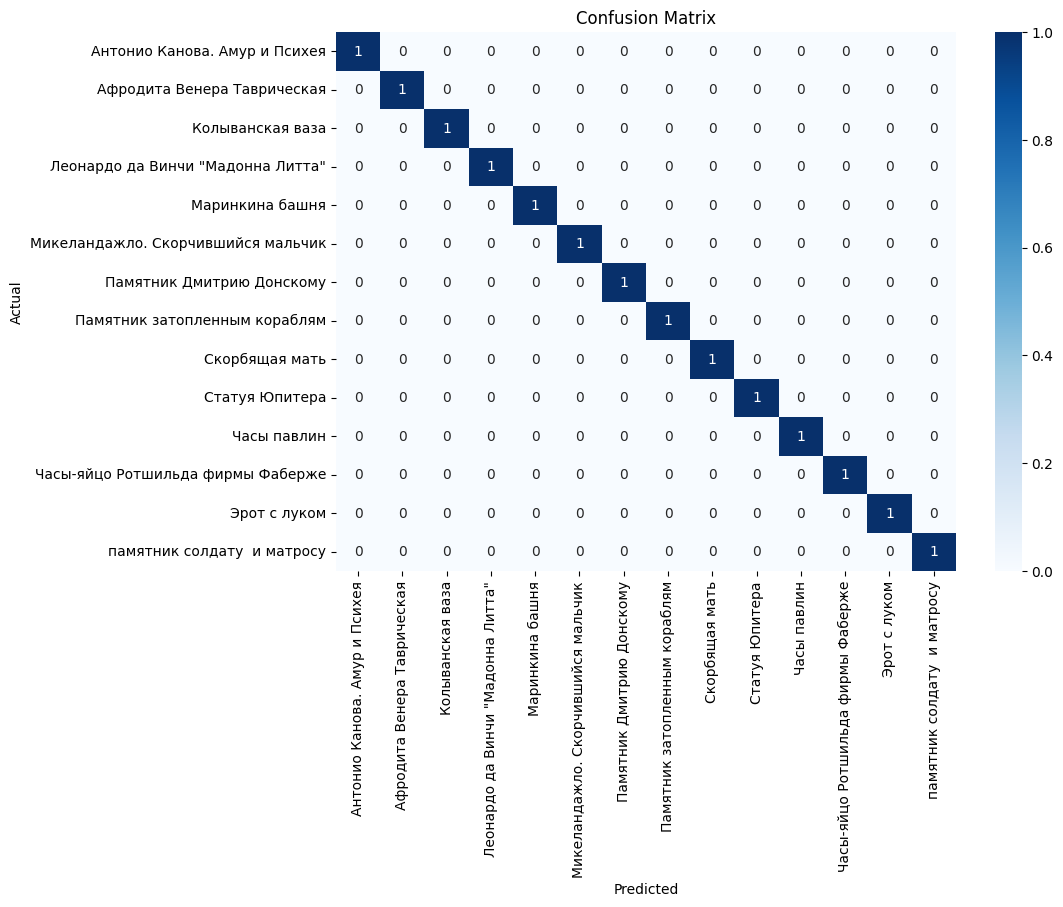

In [11]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Подсчет меток и предсказаний
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Визуализация
plot_confusion_matrix(true_labels, predicted_labels, classes=test_loader.dataset.classes)


In [12]:
from sklearn.metrics import classification_report

# Получаем текстовый отчет
report = classification_report(true_labels, predicted_labels, target_names=test_loader.dataset.classes)
print(report)


                                    precision    recall  f1-score   support

     Антонио Канова. Амур и Психея       1.00      1.00      1.00         1
       Афродита Венера Таврическая       1.00      1.00      1.00         1
                  Колыванская ваза       1.00      1.00      1.00         1
 Леонардо да Винчи "Мадонна Литта"       1.00      1.00      1.00         1
                   Маринкина башня       1.00      1.00      1.00         1
Микеландажло. Скорчившийся мальчик       1.00      1.00      1.00         1
         Памятник Дмитрию Донскому       1.00      1.00      1.00         1
     Памятник затопленным кораблям       1.00      1.00      1.00         1
                    Скорбящая мать       1.00      1.00      1.00         1
                    Статуя Юпитера       1.00      1.00      1.00         1
                       Часы павлин       1.00      1.00      1.00         1
 Часы-яйцо Ротшильда фирмы Фаберже       1.00      1.00      1.00         1
           

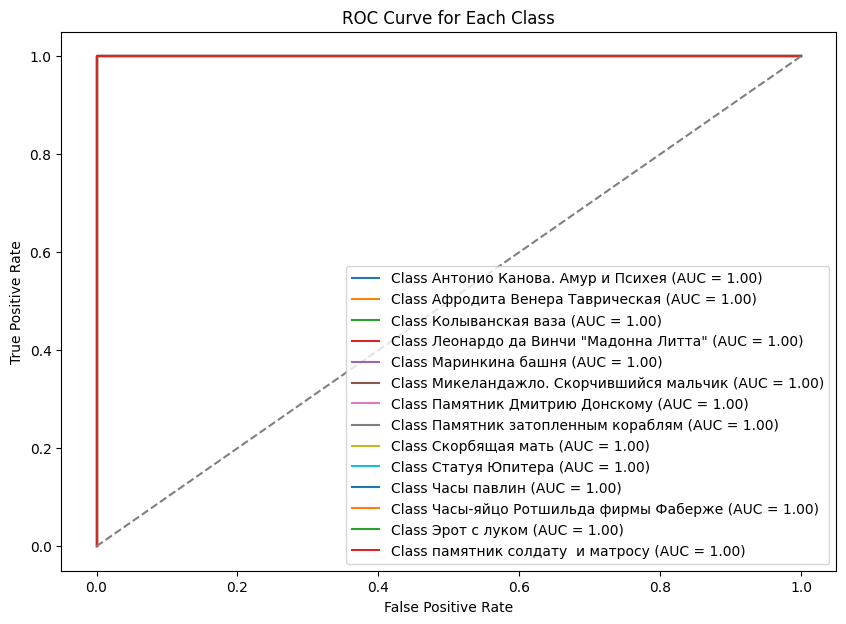

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Бинаризация меток для многоклассовой задачи
y_true_bin = label_binarize(true_labels, classes=range(len(test_loader.dataset.classes)))

# Получение вероятностей для каждого класса
model.eval()
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Получаем вероятности
        all_probs.extend(probs.cpu().numpy())

# Вычисление ROC и AUC для каждого класса
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(test_loader.dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], [x[i] for x in all_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Плотим ROC кривые
plt.figure(figsize=(10, 7))
for i in range(len(test_loader.dataset.classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {test_loader.dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


In [14]:
import time

# Перемещение модели на GPU (если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Выбираем одно изображение из тестового набора
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Измерение времени инференса на одном изображении
start_time = time.time()  # Начинаем замер времени
outputs = model(inputs)  # Инференс
end_time = time.time()  # Заканчиваем замер времени

# Вычисление времени на одно изображение
elapsed_time = end_time - start_time
print(f"Inference Time on One Image: {elapsed_time:.6f} seconds")


Inference Time on One Image: 0.012774 seconds
